Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

from scipy.optimize import root_scalar

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [4]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

In [5]:
moffat_params = Table.read('/Users/rongpu/Documents/Data/desi_misc/bright_star_profiles/survey-ccds-decam-dr9-cut-psfex-moffat-params-subsample.fits')
idx = np.random.choice(len(moffat_params), size=len(moffat_params), replace=False)
moffat_params = moffat_params[idx]
moffat_params = moffat_params[np.unique(moffat_params['expnum'], return_index=True)[1]]
print(len(moffat_params))

moffat_params[:3]

1997


expnum,ccdname,psf_patch_ver,moffat_alpha,moffat_beta,sum_diff,fit_original,failure,filter
int64,bytes3,bytes7,float64,float64,float64,float64,bool,bytes1
229360,N24,d683d99,0.42859606887580975,2.0700541321747195,-0.0005784932873211801,1.000000020977199,False,r
229385,S21,d683d99,0.8746671595347031,2.490872505970563,0.0010197164956480265,1.0000004072951671,False,r
229623,S9,d683d99,1.202096252404931,2.8145285758963485,0.0002386040287092328,1.000000021725192,False,g


In [6]:
for band in ['g', 'r', 'z']:
    mask = moffat_params['filter']==band
    alpha_list, beta_list = moffat_params['moffat_alpha'][mask], moffat_params['moffat_beta'][mask]
    print(np.median(alpha_list), np.median(beta_list))

0.883931065910247 2.4965485213456655
0.6924346549304556 2.240532047157867
0.5336829302487265 2.0191190283919687


__Plot the PSF profiles (normalized to a 22.5 magnitude star)__

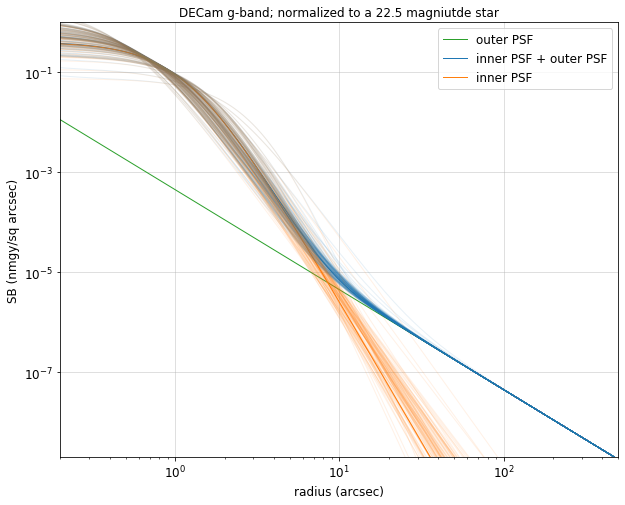

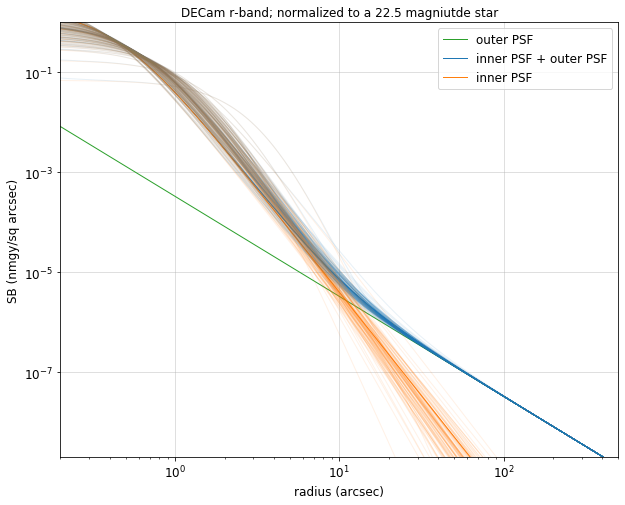

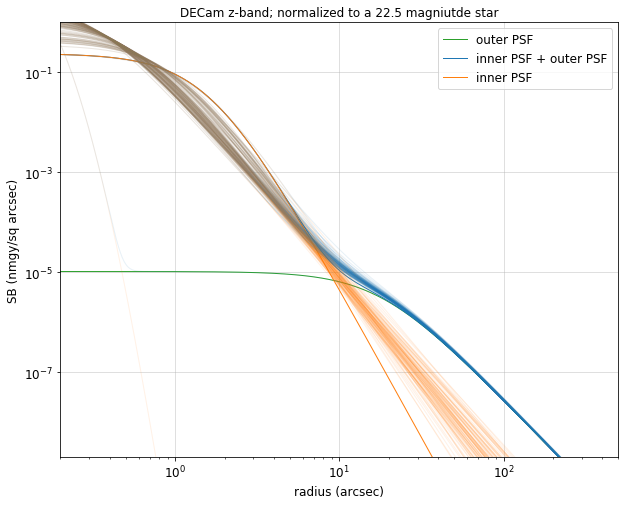

In [11]:
radius = np.logspace(-1, np.log10(500), 1000)

for band in ['g', 'r', 'z']:
    
    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    plt.figure(figsize=(10, 8))
    plt.loglog(radius, flux_outer, 'C2-', lw=1, alpha=1., label='outer PSF')
    
    mask = moffat_params['filter']==band
    alpha_list, beta_list = moffat_params['moffat_alpha'][mask], moffat_params['moffat_beta'][mask]
    
    for index in range(len(alpha_list))[:100]:
        
        alpha, beta = alpha_list[index], beta_list[index]
        
        # nanomaggies per sq arcsec:
        if band!='z':
            plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
            flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * radius**(plexp2)
        else:
            alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
            flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

        if index==0:
            plt.loglog(radius, flux_all, 'C0-', lw=1, label='inner PSF + outer PSF')
            plt.loglog(radius, flux_inner, 'C1-', lw=1, label='inner PSF')
        else:
            plt.loglog(radius, flux_all, 'C0-', lw=1, alpha=0.1)
            plt.loglog(radius, flux_inner, 'C1-', lw=1, alpha=0.1)

    plt.axis([0.2, 500, 2e-9, 1.])
    plt.grid(alpha=0.5)
    plt.title('DECam {}-band; normalized to a 22.5 magniutde star'.format(band))
    plt.xlabel('radius (arcsec)')
    plt.ylabel('SB (nmgy/sq arcsec)')
    plt.legend(markerscale=7, loc='upper right')
    plt.show()

__Plot the radius-magnitude relation (which is the inverse of the PSF profiles)__

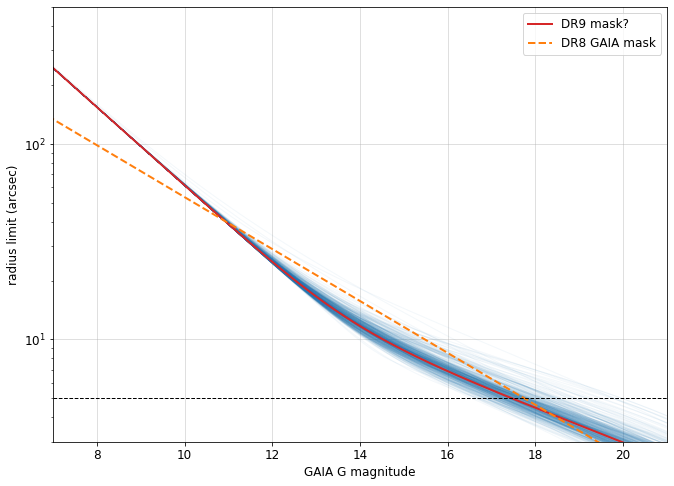

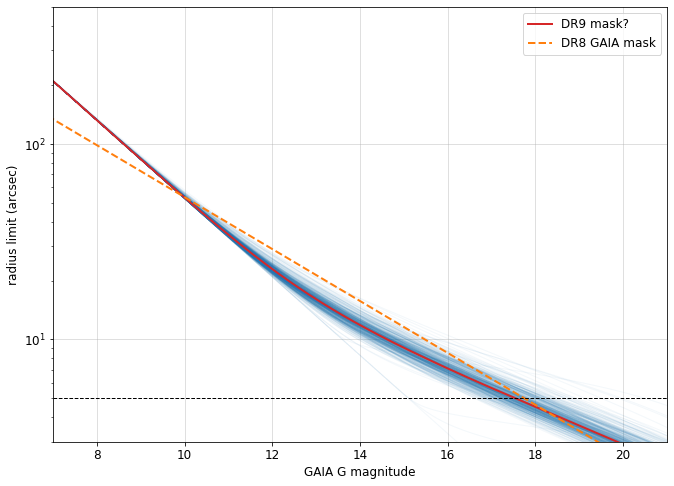

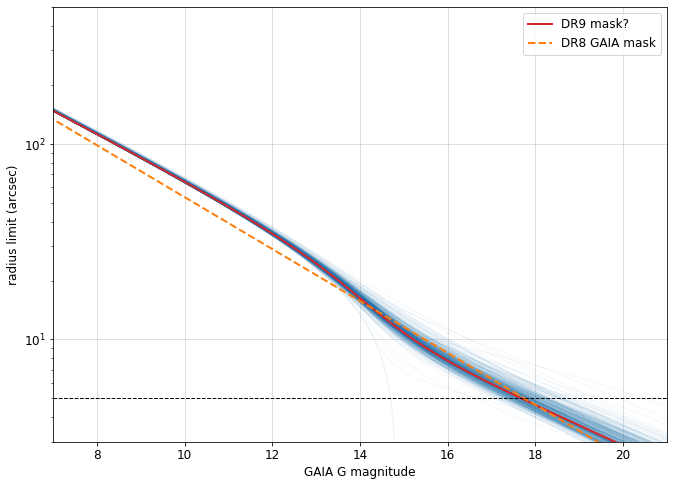

In [24]:
for band in ['g', 'r', 'z']:

    mag_offset = 0.2 # almost all stars are at least 0.2 mag fainter in DECam_g than GAIA_G

    radius = np.logspace(-1, np.log10(500), 1000)

    sb_limit_in_mag = 27.5
    sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

    mask = moffat_params['filter']==band
    alpha_list, beta_list = moffat_params['moffat_alpha'][mask], moffat_params['moffat_beta'][mask]
    alpha_median, beta_median = np.median(alpha_list), np.median(beta_list)
    # alpha_median, beta_median = 0.8, 2.2

    alpha_list1 = np.insert(alpha_list[:400], 0, alpha_median)
    beta_list1 = np.insert(beta_list[:400], 0, beta_median)

    plt.figure(figsize=(11, 8))

    for index in reversed(range(len(alpha_list1))):

        alpha, beta = alpha_list1[index], beta_list1[index]
        # print(alpha, beta)

        # nanomaggies per sq arcsec:
        if band!='z':
            plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
            flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * radius**(plexp2)
        else:
            alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
            flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

        mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
        mag_at_radius -= mag_offset # convert to GAIA-G

        # compare with DR8 GAIA mask
        gaia_radius = np.minimum(1800., 150. * 2.5**((11. - mag_at_radius)/3.)) * 0.262

        if index==0:
            plt.semilogy(mag_at_radius, radius, 'C3-', lw=2, label='DR9 mask?')
        else:
            plt.semilogy(mag_at_radius, radius, 'C0-', lw=1, alpha=0.05)

    # compare with DR8 GAIA mask
    gaia_radius = np.minimum(1800., 150. * 2.5**((11. - mag_at_radius)/3.)) * 0.262
    plt.semilogy(mag_at_radius, gaia_radius, 'C1--', lw=2, label='DR8 GAIA mask')

    plt.grid(alpha=0.5)
    # plt.title(' ')
    plt.xlabel('GAIA G magnitude')
    plt.ylabel('radius limit (arcsec)')
    plt.axhline(5., lw=1, ls='--', color='k')
    plt.axis([7, 21, 3, 500])
    plt.legend(loc='upper right')
    plt.show()

__Only look at g band__

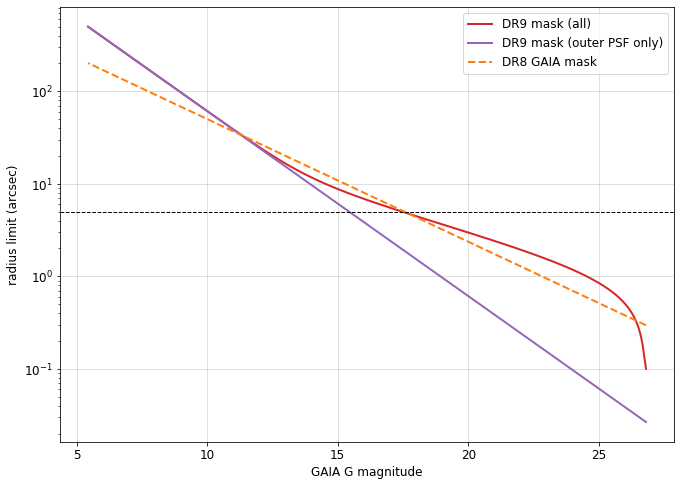

In [51]:
# for band in ['g', 'r', 'z']:

band = 'g'

mag_offset = 0.2 # almost all stars are at least 0.2 mag fainter in DECam_g than GAIA_G

radius = np.logspace(-1, np.log10(500), 1000)

sb_limit_in_mag = 27.5
sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

mask = moffat_params['filter']==band
alpha_list, beta_list = moffat_params['moffat_alpha'][mask], moffat_params['moffat_beta'][mask]
alpha_median, beta_median = np.median(alpha_list), np.median(beta_list)
# alpha_median, beta_median = 0.8, 2.2

alpha_list1 = np.insert(alpha_list[:400], 0, alpha_median)
beta_list1 = np.insert(beta_list[:400], 0, beta_median)

plt.figure(figsize=(11, 8))

alpha, beta = alpha_median, beta_median
# print(alpha, beta)

# nanomaggies per sq arcsec:
plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
flux_inner = get_sb_moffat(radius, alpha, beta)
flux_outer = weight2 * radius**(plexp2)

mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
gaia_mag_at_radius = mag_at_radius - mag_offset # convert to GAIA-G
radius_outer = (sb_limit_in_nmgy/(10**((22.5-(gaia_mag_at_radius+mag_offset))/2.5)*weight2))**(-0.5)

# compare with DR8 GAIA mask
gaia_radius = np.minimum(1800., 150. * 2.5**((11. - mag_at_radius)/3.)) * 0.262
plt.semilogy(gaia_mag_at_radius, radius, 'C3-', lw=2, label='DR9 mask (all)')
plt.semilogy(gaia_mag_at_radius, radius_outer, 'C4-', lw=2, label='DR9 mask (outer PSF only)')

# compare with DR8 GAIA mask
gaia_radius = np.minimum(1800., 150. * 2.5**((11. - mag_at_radius)/3.)) * 0.262
plt.semilogy(gaia_mag_at_radius, gaia_radius, 'C1--', lw=2, label='DR8 GAIA mask')

plt.grid(alpha=0.5)
# plt.title(' ')
plt.xlabel('GAIA G magnitude')
plt.ylabel('radius limit (arcsec)')
plt.axhline(5., lw=1, ls='--', color='k')
# plt.axis([7, 21, 3, 500])
plt.legend(loc='upper right')
plt.show()

In [68]:
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/bright_star_profiles/brightest_gaia_stars-south.fits')
print(len(gaia))
gaia[:3]

79935


source_id,ref_cat,ra,dec,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,phot_bp_rp_excess_factor,astrometric_excess_noise,duplicated_source,astrometric_sigma5d_max,astrometric_params_solved,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,bp_rp,pm,ls_g,ls_r,ls_z
int64,bytes2,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64
486067156903396736,G2,88.08250093178752,71.11348425938007,8.954781,4998.622,9.622139,866.95764,8.206947,779.60803,1.2448306,0.0,False,0.032096334,True,2.3194304,0.026155017,3.5698793,0.033566743,5.164257,0.04247901,1.4151917,6.278024,9.81639454205256,8.800498209637716,8.307229411968486
485926178897433856,G2,84.6044066663347,70.34270231771424,9.966823,6435.7056,10.306264,1372.928,9.495115,1401.5369,1.194147,0.0,False,0.030762281,True,3.9493873,0.026394876,22.983978,0.0343432,-40.165497,0.040753707,0.81114864,46.276672,10.301577391437867,9.885656317121596,9.760737039752225
485844505799768960,G2,83.5166102459733,69.66110329321465,7.719376,4953.83,7.987277,1199.34,7.335601,1028.3335,1.179501,0.0,False,0.038893733,True,11.06827,0.031654835,-9.713188,0.038900692,76.19839,0.055436272,0.6516762,76.81498,7.952053694496285,7.672005489572593,7.623863752462278


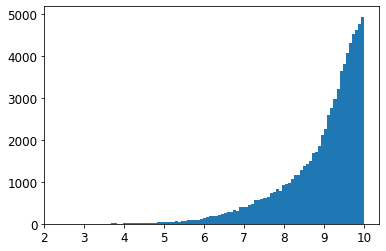

In [69]:
plt.hist(gaia['phot_g_mean_mag'], 100);

In [71]:
mask_radii = (sb_limit_in_nmgy/(10**((22.5-(gaia['ls_g']))/2.5)*weight2))**(-0.5)

ramin, ramax, decmin, decmax = 240, np.inf, 0, 30
gaia_list = np.where((gaia['ra']>ramin) & (gaia['ra']<ramax) & (gaia['dec']>decmin) & (gaia['dec']<decmax))[0]

tt = Table()
tt['ra'], tt['dec'] = gaia['ra'], gaia['dec']
tt['radius'] = mask_radii
tt = tt[gaia_list]
tt.write('/Users/rongpu/Downloads/viewer_ls_g_1.fits', overwrite=True)

1318


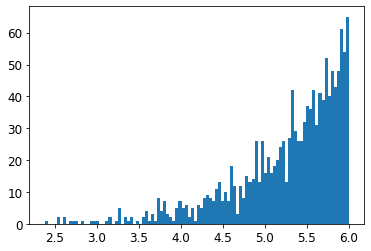

In [57]:
mask = gaia['phot_g_mean_mag']<6
gaia = gaia[mask]
print(len(gaia))
plt.hist(gaia['phot_g_mean_mag'], 100);

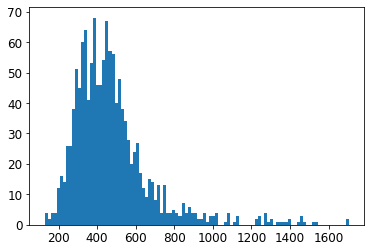

In [64]:
# mask_radii = (sb_limit_in_nmgy/(10**((22.5-(gaia['phot_g_mean_mag']+mag_offset))/2.5)*weight2))**(-0.5)
mask_radii = (sb_limit_in_nmgy/(10**((22.5-(gaia['ls_g']))/2.5)*weight2))**(-0.5)
# mask_radii = mask_radii/2
plt.hist(mask_radii, 100);

In [66]:
tt = Table()
tt['ra'], tt['dec'] = gaia['ra'], gaia['dec']
tt['radius'] = mask_radii
tt.write('/Users/rongpu/Downloads/viewer_ls_g.fits', overwrite=True)